# Solving and Simulation

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# parameters
ρ = 0.05 # discount rate
α = 0.3 # capital elasticity
δ = 0.1 # depreciation
θ = 1.0 # crra param

## Ramsey Model

In [5]:
# algorithm
S0 = 2**16 # max number of steps in perturbation simulation
S1 = 4096 # short simulation
K = 512 # size of capital grid
ptol = 1.0e-4 # initial displacement for perturbation simulation
dt_max = 1.0 # max time step in variable delt schemes

In [6]:
# steady state
k_ss = (α/(ρ+δ))**(1.0/(1.0-α))
i_ss = δ*k_ss
y_ss = k_ss**α
c_ss = y_ss - i_ss

In [7]:
# grid it up
k_lo, k_hi = 0.01, 2.0*k_ss
k_grid = np.linspace(k_lo, k_hi, K)

In [8]:
def simulate_ramsey(k0, c0, k_lo=0, k_hi=None, gk_targ=0.001, dt=None, S=S0, direc=-1):
    # initial values
    k, c = k0, c0
    kpath, cpath = [k], [c]

    for t in range(S):
        # growth rates
        gk = k**(α-1) - δ - c/k
        gc = (1/θ)*(α*k**(α-1)-(ρ+δ))

        # adaptive step size
        dt1 = direc*np.minimum(dt_max, gk_targ/np.abs(gk)) if dt is None else dt
        k *= 1 + dt1*gk
        c *= 1 + dt1*gc

        # store
        kpath.append(k)
        cpath.append(c)

        # terminal condition
        if k_lo is not None and k <= k_lo:
            break
        if k_hi is not None and k >= k_hi:
            break

    return np.array(kpath), np.array(cpath)

In [9]:
# generate upper and lower paths
kvec1, cvec1 = simulate_ramsey(k_ss-ptol, c_ss-ptol, k_lo, k_hi)
kvec2, cvec2 = simulate_ramsey(k_ss+ptol, c_ss+ptol, k_lo, k_hi)

# combined path
kvec = np.concatenate([kvec1[::-1], kvec2])
cvec = np.concatenate([cvec1[::-1], cvec2])

# interpolate
cpol = interp.interp1d(kvec, cvec)

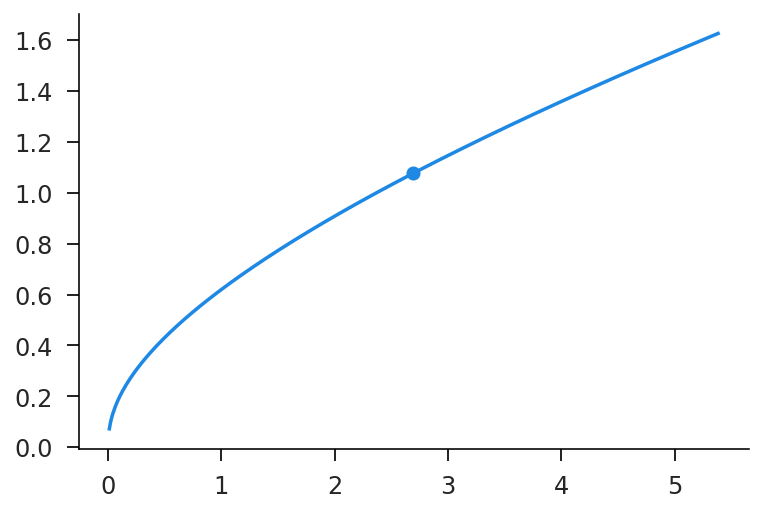

In [10]:
c_grid = cpol(k_grid)

# plot results
fig, ax = plt.subplots()
ax.plot(k_grid, c_grid);
ax.scatter([k_ss], [c_ss]);

In [11]:
def forward_ramsey(k0, cf, dt=0.01, S=S0):
    # initial values
    k, c = k0, cf(k0)
    kpath, cpath = [k], [c]

    for t in range(S):
        gk = k**(α-1) - δ - c/k

        k *= 1 + dt*gk
        c = cf(k)

        # store
        kpath.append(k)
        cpath.append(c)

    return np.array(kpath), np.array(cpath)

In [12]:
def solow_policy(s):
    return lambda k: (1-s)*k**α

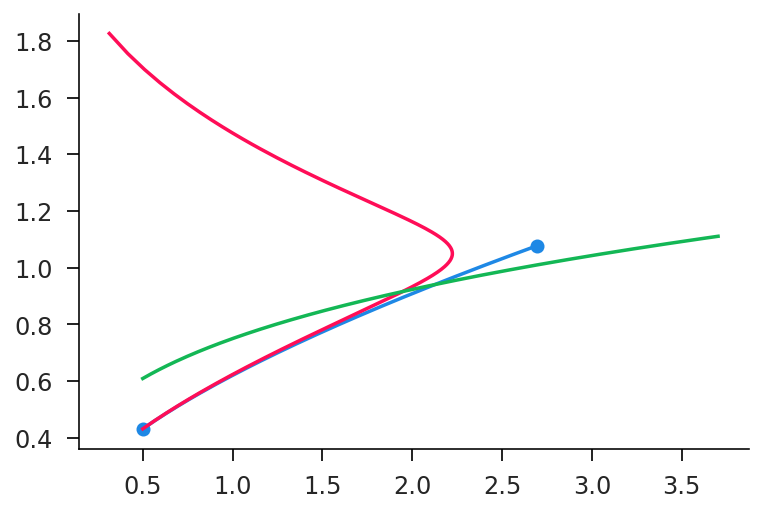

In [13]:
k0 = 0.5
c0 = float(cpol(k0))

csol = solow_policy(0.25)

dt = 0.1
kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
ksol, csol = forward_ramsey(k0, csol, dt=dt, S=S1)
ksim, csim = simulate_ramsey(k0, c0, dt=dt, k_lo=0.4, direc=1)

fig, ax = plt.subplots()
ax.plot(kfwd, cfwd);
ax.plot(ksim, csim);
ax.plot(ksol, csol);
ax.scatter([k0, k_ss], [c0, c_ss]);

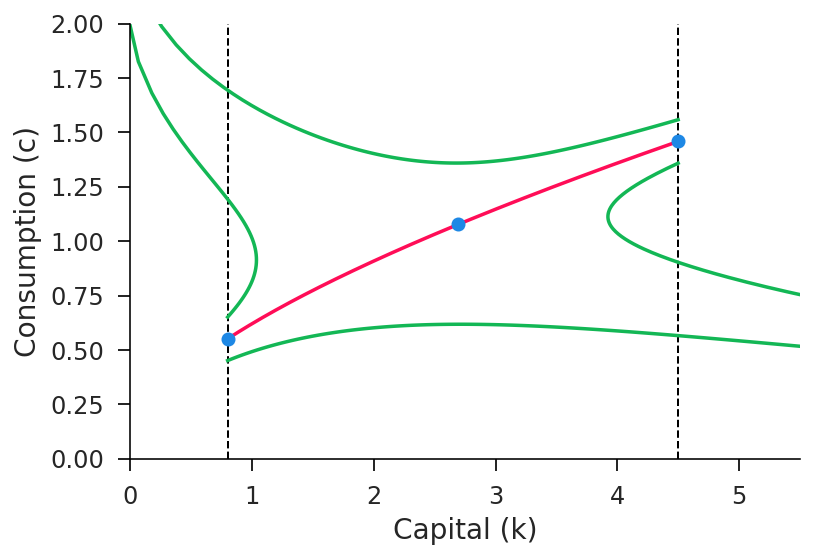

In [14]:
kv0 = [0.8, 4.5]
cv0 = cpol(kv0)
dt = 0.1
err = 0.1

fig, ax = plt.subplots()

for k0, c0 in zip(kv0, cv0):
    kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
    ksim1, csim1 = simulate_ramsey(k0, c0-err, dt=dt, k_hi=6.0, S=S1, direc=1)
    ksim2, csim2 = simulate_ramsey(k0, c0+err, dt=dt, k_hi=6.0, S=S1, direc=1)

    ax.plot(kfwd, cfwd, color=col[1]);
    ax.plot(ksim1, csim1, color=col[2]);
    ax.plot(ksim2, csim2, color=col[2]);
    ax.vlines(k0, 0, 2, color='k', linestyle='--', linewidth=1);
    
ax.scatter(kv0, cv0, color=col[0], zorder=3);
ax.scatter([k_ss], [c_ss], color=col[0], zorder=3);

ax.set_xlim(0, 5.5);
ax.set_ylim(0, 2);

ax.set_xlabel('Capital (k)');
ax.set_ylabel('Consumption (c)');

## Exercise

1. Simulate a pre-announced policy change, such as a capital gains tax.

## Value Functions with JAX

In [15]:
import valjax as vj
import jax
import jax.numpy as npx
import numpy as np0
from jax import lax

In [16]:
# fixed params
T = 300 # time periods
N = 100 # grid size
f_lo, f_hi = 0.5, 2.0 # proportional grid range

In [17]:
# simple parameters
par0 = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

In [18]:
# find steady state
def get_kss(par):
    β, δ, z, α = par['β'], par['δ'], par['z'], par['α']
    rhs = (1-β)/β + δ
    k = (α*z/rhs)**(1/(1-α))
    return k
k_ss = get_kss(par0)

In [19]:
# construct capital grid
k_min = f_lo*k_ss
k_max = f_hi*k_ss
k_grid = npx.linspace(k_min, k_max, N)

In [20]:
# defined functions
def util(c, eps=1e-6):
    c1 = npx.maximum(eps, c)
    return npx.log(c1)
def prod(k, z, α):
    return z*k**α

In [21]:
def value(par, grid, st, tv, np=npx):
    β = par['β']
    cp = grid['cp']
    vn = st['vn']

    # calculate optimal investment
    vp = util(cp) + β*vn[None,:]
    ip = np.argmax(vp, axis=1)

    # apply at values
    kp = k_grid[ip]
    v = vj.address(vp, ip, axis=-1)
    
    # compute update errors
    err = np.max(np.abs(v-vn))

    # return state and output
    stp = {
        'vn': v,
    }    
    out = {
        'v': v,
        'kp': kp,
        'err': err,
    }
    
    return stp, out

In [22]:
def solve(par, T):
    α = par['α']
    δ = par['δ']
    z = par['z']

    # precompute grid values
    y_grid = prod(k_grid, z, α)
    yd_grid = y_grid + (1-δ)*k_grid
    cp_grid = yd_grid[:,None] - k_grid[None,:]

    # partially apply grid
    grid = {
        'cp': cp_grid,
    }
    value1 = jax.partial(value, par, grid)

    # scan over time (backwards)
    st0 = {
        'vn': util(y_grid),
    }
    tv = {
        't': np.arange(T)[::-1],
    }
    last, path = lax.scan(value1, st0, tv)

    return path

In [23]:
jsolve = jax.jit(solve, static_argnums=(1,))

In [24]:
ret = jsolve(par0, T)

In [25]:
%timeit -r 10 -n 10 jsolve(par0, T)

6.42 ms ± 112 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


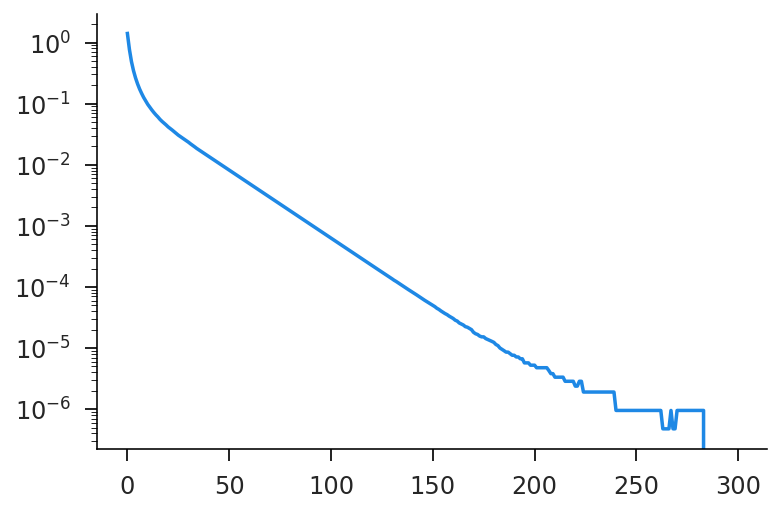

In [26]:
plt.plot(ret['err'])
plt.yscale('log');

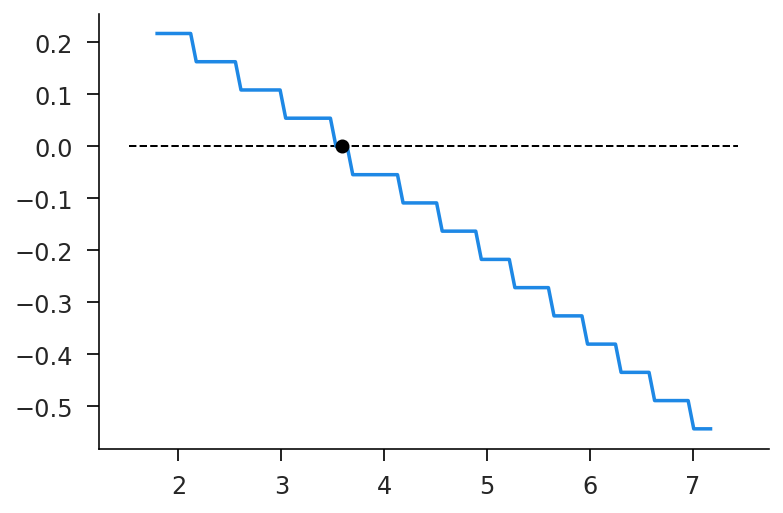

In [27]:
fig, ax = plt.subplots()
ax.plot(k_grid, ret['kp'][-1, :]-k_grid);
ax.hlines(0, *ax.get_xlim(), linestyle='--', linewidth=1, color='k')
ax.scatter(k_ss, 0, color='k', zorder=10);

## Exercise

1. Redo the Ramsey path finding with JAX